# Binning and summarizing glider data using boxplots

_Written by Lori Garzio, June 28, 2023_

[Rutgers Center for Ocean Observing Leadership](https://rucool.marine.rutgers.edu/) (RUCOOL)

This notebook shows you how to group data according to depth (surface vs bottom water) and distance from shore (nearshore, mid-shelf, offshore) using 1m depth-binned and 1km-distance binned glider data, and summarize the data using boxplots. In this example we will be summarizing temperature data from files that I have manually downloaded from the [IOOS Glider DAC ERDDAP server](https://gliders.ioos.us/erddap/index.html) and manipulated. I [calculated mixed layer depth](https://github.com/lgarzio/noaa-oap/blob/master/glider_analyses/calculate_mld.py), [selected one cross-shelf transect and calculated distance from shore after manually selecting shoreline coordinates](https://github.com/lgarzio/noaa-oap/blob/master/glider_analyses/subset_ds.py). Files containing a single cross-shelf transect and additional variables can be found [here](https://marine.rutgers.edu/~lgarzio/phglider/WCR_analysis/files/).

Surface and bottom waters will be split up using the Mixed Layer Depth (MLD) that's calculated for each profile. In cases where MLD is not determined for a profile (for instance, if the profile is well-mixed), data from that profile is left out of the analysis. Shelf locations on the continental shelf off New Jersey (nearshore, mid-shelf, offshore) are defined using the average profile maximum depth for each 1km distance bin: nearshore = avg profile depth < 36m, midshelf = avg profile depth >=36m and <60m, offshore = avg profile depth >=60m.

Box plot summaries are generated using matplotlib's boxplot function. Check out the [boxplot documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html) for all of the different options and configurations. In this example, the box limits extend from the lower to upper quartiles (25%, 75%), with a line at the median and a diamond symbol at the mean. The whiskers extend from the box by 1.5x the inter-quartile range (IQR). Circles indicate outliers. Notch indicates 95% CI around the median.

In [1]:
# import required packages
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Specify the file path for the dataset you would like to summarize and load it using xarray.

In [2]:
f = '/Users/garzio/Documents/rucool/gliderdata/ru30-20190717T1812-delayed-transect1.nc'
ds = xr.open_dataset(f)

Specify where you want the plots to be saved on your local machine.

In [3]:
save_dir = '/Users/garzio/Documents/rucool/gliderplots'

Look at the dataset for variables, time range, etc.

In [4]:
ds

<xarray.Dataset>
Dimensions:                     (time: 362329)
Coordinates:
  * time                        (time) datetime64[ns] 2019-07-17T16:28:21.468...
Data variables: (12/22)
    latitude                    (time) float64 ...
    longitude                   (time) float64 ...
    depth                       (time) float32 ...
    aragonite_saturation_state  (time) float64 ...
    chlorophyll_a               (time) float64 ...
    conductivity                (time) float32 ...
    ...                          ...
    salinity                    (time) float32 ...
    temperature                 (time) float32 ...
    total_alkalinity            (time) float64 ...
    mld                         (time) float64 ...
    mld_dbar                    (time) float64 ...
    dist_from_shore_km          (time) float64 ...
Attributes: (12/67)
    acknowledgment:                  This deployment supported by National Sc...
    cdm_data_type:                   TrajectoryProfile
    cdm_profile_variables:           time_uv,lat_uv,lon_uv,u,v,profile_id,tim...
    cdm_trajectory_variables:        trajectory,wmo_id
    comment:                         Deployed by Chip Haldeman, Nicole Waite,...
    contributor_name:                Grace Saba,Travis Miles,Liza Wright-Fair...
    ...                              ...
    subsetVariables:                 wmo_id,trajectory,profile_id,time,latitu...
    summary:                         This project integrated a deep rated ver...
    time_coverage_end:               2019-08-12T15:14:53Z
    time_coverage_start:             2019-07-17T16:28:21Z
    title:                           ru30-20190717T1812-delayed
    Westernmost_Easting:             -73.84989712666668

Get the deployment name from the global attributes from the file. This is always good to have for file naming and adding titles to plots.

In [5]:
deployment_id = ds.title
deployment_id

'ru30-20190717T1812-delayed'

Next, print the temperature variable. The attributes will give you some important information about the variable, such as units.

In [6]:
ds.temperature

<xarray.DataArray 'temperature' (time: 362329)>
[362329 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2019-07-17T16:28:21.468749824 ... 2019-07-...
Attributes: (12/14)
    _ChunkSizes:          118
    actual_range:         [ 6.2561 27.2022]
    ancillary_variables:  qartod_temperature_flat_line_flag qartod_temperatur...
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    instrument:           instrument_ctd
    ...                   ...
    observation_type:     measured
    platform:             platform
    standard_name:        sea_water_temperature
    units:                Celsius
    valid_max:            40.0
    valid_min:            -5.0

The dataset right now is structured as a time series, so we will need to group the data by profile and bin the data in 1m depth bins and 1km distance from shore bins. Convert the dataset to a dataframe and drop all columns except depth, temperature, mixed layer depth, and distance from shore. If depth_interpolated is available in the dataset, use that depth. If it's not available (it's not available for this deployment), use depth instead.

In [7]:
df = ds.to_dataframe()
df = df[['depth', 'temperature', 'mld', 'dist_from_shore_km']]
df

,depth,temperature,mld,dist_from_shore_km
time,,,,
2019-07-17 16:28:21.468749824,6.777343,20.468901,8.056037,17.593352
2019-07-17 16:28:21.468749824,7.591006,19.826300,8.056037,17.593352
2019-07-17 16:28:21.468749824,8.007759,19.392000,8.056037,17.593352
2019-07-17 16:28:21.468749824,9.019870,18.928499,8.056037,17.593352
2019-07-17 16:28:21.468749824,8.781726,18.625299,8.056037,17.593352
...,...,...,...,...
2019-07-27 23:41:09.524229376,3.751086,23.943399,19.901507,196.478610
2019-07-27 23:41:09.524229376,3.503001,23.947599,19.901507,196.478610
2019-07-27 23:41:09.524229376,4.068635,23.953800,19.901507,196.478610


Now, we'll group the data by time because, in these datasets, the "time" variable is unique to each profile. Note that if you're using a different dataset from a different source, time might not be unique to the profile and you might need to find a profile_time or profile_id variable. To illustrate the next step, I'll grab the first "group" (which is the first profile) and bin the data into 1m depth bins (from 0 to depth_max that we calculated for the entire transect).

In [8]:
grouped = df.groupby('time')
grouped

This groupby function returns a DataFrameGroupBy object. To look at the groups internally you have to iterate through each group, but first we'll just access the first group by using get_group(). From the dataframe above we know the first group timestamp is 2019-07-17 16:28:21.468749824 so we will use that (the group name since the dataframe was grouped by time) to grab that first profile.

In [9]:
profile1 = grouped.get_group('2019-07-17 16:28:21.468749824')
profile1

,depth,temperature,mld,dist_from_shore_km
time,,,,
2019-07-17 16:28:21.468749824,6.777343,20.468901,8.056037,17.593352
2019-07-17 16:28:21.468749824,7.591006,19.826300,8.056037,17.593352
2019-07-17 16:28:21.468749824,8.007759,19.392000,8.056037,17.593352
2019-07-17 16:28:21.468749824,9.019870,18.928499,8.056037,17.593352
2019-07-17 16:28:21.468749824,8.781726,18.625299,8.056037,17.593352
2019-07-17 16:28:21.468749824,8.771804,18.332600,8.056037,17.593352
2019-07-17 16:28:21.468749824,9.783911,17.800800,8.056037,17.593352
2019-07-17 16:28:21.468749824,10.498336,17.557899,8.056037,17.593352
2019-07-17 16:28:21.468749824,10.518181,17.189301,8.056037,17.593352


There's the first profile in this dataset. The glider collected data from about 7m - 18m, mixed layer depth is around 8m, and the glider was about 17km from shore during this profile. Let's bin this dataset into 1m depth bins.

In [10]:
depth_max = np.nanmax(profile1.depth)
bins = np.arange(0, depth_max+1, 1)  # Generate array of depths from 0 to depth_max at 1m increments
cut = pd.cut(profile1['depth'], bins)  # Cut/Bin the dataframe based on the bins variable we just generated
binned_df = profile1.groupby(cut).mean()  # Groupby the cut and generate the average temperature for each bin
binned_df

,depth,temperature,mld,dist_from_shore_km
depth,,,,
"(0.0, 1.0]",NaN,NaN,NaN,NaN
"(1.0, 2.0]",NaN,NaN,NaN,NaN
"(2.0, 3.0]",NaN,NaN,NaN,NaN
"(3.0, 4.0]",NaN,NaN,NaN,NaN
"(4.0, 5.0]",NaN,NaN,NaN,NaN
"(5.0, 6.0]",NaN,NaN,NaN,NaN
"(6.0, 7.0]",6.777343,20.468901,8.056037,17.593352
"(7.0, 8.0]",7.591006,19.826300,8.056037,17.593352
"(8.0, 9.0]",8.520430,18.783300,8.056037,17.593352


We don't need to keep empty rows of data so let's drop those.

In [11]:
binned_df.dropna(subset=['depth'], inplace=True)
binned_df

,depth,temperature,mld,dist_from_shore_km
depth,,,,
"(6.0, 7.0]",6.777343,20.468901,8.056037,17.593352
"(7.0, 8.0]",7.591006,19.826300,8.056037,17.593352
"(8.0, 9.0]",8.520430,18.783300,8.056037,17.593352
"(9.0, 10.0]",9.401890,18.364651,8.056037,17.593352
"(10.0, 11.0]",10.523142,17.140100,8.056037,17.593352
"(11.0, 12.0]",11.440977,16.738100,8.056037,17.593352
"(12.0, 13.0]",12.659457,16.152901,8.056037,17.593352
"(13.0, 14.0]",13.537923,15.493667,8.056037,17.593352
"(14.0, 15.0]",14.487165,15.436200,8.056037,17.593352


Add new columns to this profile data frame that specifies the depth-bin and distance-bin for the profile.

In [12]:
binned_df['depth_bin_1m'] = np.round(binned_df['depth'])
binned_df['dist_from_shore_bin_1km'] = np.round(binned_df['dist_from_shore_km'])
binned_df

,depth,temperature,mld,dist_from_shore_km,depth_bin_1m,dist_from_shore_bin_1km
depth,,,,,,
"(6.0, 7.0]",6.777343,20.468901,8.056037,17.593352,7.0,18.0
"(7.0, 8.0]",7.591006,19.826300,8.056037,17.593352,8.0,18.0
"(8.0, 9.0]",8.520430,18.783300,8.056037,17.593352,9.0,18.0
"(9.0, 10.0]",9.401890,18.364651,8.056037,17.593352,9.0,18.0
"(10.0, 11.0]",10.523142,17.140100,8.056037,17.593352,11.0,18.0
"(11.0, 12.0]",11.440977,16.738100,8.056037,17.593352,11.0,18.0
"(12.0, 13.0]",12.659457,16.152901,8.056037,17.593352,13.0,18.0
"(13.0, 14.0]",13.537923,15.493667,8.056037,17.593352,14.0,18.0
"(14.0, 15.0]",14.487165,15.436200,8.056037,17.593352,14.0,18.0


Separate surface and bottom waters for the profile based on the calculated mixed layer depth.

In [13]:
profile_mld = np.nanmean(binned_df.mld)
surface_df = binned_df[binned_df.depth_bin_1m <= profile_mld]
bottom_df = binned_df[binned_df.depth_bin_1m > profile_mld]

Check the surface dataframe and bottom dataframe

In [14]:
surface_df

,depth,temperature,mld,dist_from_shore_km,depth_bin_1m,dist_from_shore_bin_1km
depth,,,,,,
"(6.0, 7.0]",6.777343,20.468901,8.056037,17.593352,7.0,18.0
"(7.0, 8.0]",7.591006,19.826300,8.056037,17.593352,8.0,18.0


In [15]:
bottom_df

,depth,temperature,mld,dist_from_shore_km,depth_bin_1m,dist_from_shore_bin_1km
depth,,,,,,
"(8.0, 9.0]",8.520430,18.783300,8.056037,17.593352,9.0,18.0
"(9.0, 10.0]",9.401890,18.364651,8.056037,17.593352,9.0,18.0
"(10.0, 11.0]",10.523142,17.140100,8.056037,17.593352,11.0,18.0
"(11.0, 12.0]",11.440977,16.738100,8.056037,17.593352,11.0,18.0
"(12.0, 13.0]",12.659457,16.152901,8.056037,17.593352,13.0,18.0
"(13.0, 14.0]",13.537923,15.493667,8.056037,17.593352,14.0,18.0
"(14.0, 15.0]",14.487165,15.436200,8.056037,17.593352,14.0,18.0
"(15.0, 16.0]",15.288395,15.094151,8.056037,17.593352,15.0,18.0
"(16.0, 17.0]",16.747467,14.263140,8.056037,17.593352,17.0,18.0


Now that we've practiced binning the data and separating the profile into surface and bottom waters, let's loop through each profile and build surface- and bottom-water dataframes for the entire transect. This section of code might take a few seconds because it's looping through each profile in the dataset. Once we've completed that step, we'll group those dataframes into 1km distance from shore bins.

In [16]:
# start with empty dataframes for surface and bottom
cols = ['depth', 'temperature', 'mld', 'dist_from_shore_km', 'depth_bin_1m', 
        'dist_from_shore_bin_1km', 'profile_maxz']
df_surface = pd.DataFrame(columns=cols)
df_bottom = pd.DataFrame(columns=cols)

# loop through each profile, split into surface and bottom dataframes, and append those dataframes to 
# the empty dataframes we just created
for group in grouped:
    depth_max = np.nanmax(group[1].depth)
    bins = np.arange(0, depth_max+1, 1)  # Generate array of depths from 0 to depth_max at 1m increments
    cut = pd.cut(group[1]['depth'], bins)  # Cut/Bin the dataframe based on the bins variable we just generated
    binned_df = group[1].groupby(cut).mean()  # Groupby the cut and generate the average temperature for each bin
    binned_df.dropna(subset=['depth'], inplace=True)  # drop the NaNs
    profile_mld = np.nanmean(binned_df.mld)
    if np.isnan(profile_mld):  # if MLD isn't defined, throw out the profile
        continue
    
    # add the depth-bin, distance-bin, and max profile depth to the dataframe
    binned_df['depth_bin_1m'] = np.round(binned_df['depth'])
    binned_df['dist_from_shore_bin_1km'] = np.round(binned_df['dist_from_shore_km'])
    binned_df['profile_maxz'] = np.nanmax(binned_df.depth)
    
    # separate surface and bottom waters using the MLD for the profile
    temp_surf_df = binned_df[binned_df.depth_bin_1m <= profile_mld]
    temp_bottom_df = binned_df[binned_df.depth_bin_1m > profile_mld]
    
    # append data from this profile to the master dataframes
    df_surface = pd.concat([df_surface, temp_surf_df], ignore_index=True)
    df_bottom = pd.concat([df_bottom, temp_bottom_df], ignore_index=True)

/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7w

/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7w

/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7w

/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_33848/3195284970.py:15: RuntimeWarning: Mean of empty slice
  profile_mld = np.nanmean(binned_df.mld)
/var/folders/_h/5x4zz6xx04s4g8bp7w

Now look at the master dataframes we generated for surface and bottom waters.

In [17]:
df_surface

,depth,temperature,mld,dist_from_shore_km,depth_bin_1m,dist_from_shore_bin_1km,profile_maxz
0,6.777343,20.468901,8.056037,17.593352,7.0,18.0,18.088953
1,7.591006,19.826300,8.056037,17.593352,8.0,18.0,18.088953
2,0.424080,24.888605,6.978517,17.605836,0.0,18.0,18.088953
3,1.396667,24.881525,6.978517,17.605836,1.0,18.0,18.088953
4,2.302139,24.569901,6.978517,17.605836,2.0,18.0,18.088953
...,...,...,...,...,...,...,...
19287,14.366882,23.387419,19.901507,196.478610,14.0,196.0,192.305054
19288,15.402830,22.990299,19.901507,196.478610,15.0,196.0,192.305054
19289,16.522125,22.573349,19.901507,196.478610,17.0,196.0,192.305054
19290,17.638437,22.028126,19.901507,196.478610,18.0,196.0,192.305054


In [18]:
df_bottom

,depth,temperature,mld,dist_from_shore_km,depth_bin_1m,dist_from_shore_bin_1km,profile_maxz
0,8.520430,18.783300,8.056037,17.593352,9.0,18.0,18.088953
1,9.401890,18.364651,8.056037,17.593352,9.0,18.0,18.088953
2,10.523142,17.140100,8.056037,17.593352,11.0,18.0,18.088953
3,11.440977,16.738100,8.056037,17.593352,11.0,18.0,18.088953
4,12.659457,16.152901,8.056037,17.593352,13.0,18.0,18.088953
...,...,...,...,...,...,...,...
92045,188.640030,13.598800,19.901507,196.478610,189.0,196.0,192.305054
92046,189.227463,13.588025,19.901507,196.478610,189.0,196.0,192.305054
92047,190.476166,13.581759,19.901507,196.478610,190.0,196.0,192.305054
92048,191.538986,13.585119,19.901507,196.478610,192.0,196.0,192.305054


Now that we've split the data into surface and bottom, we can bin the data by distance from shore. The resulting dataframes contain the average values for each distance from shore bin.

In [19]:
# bin the dataframes by distance from shore
df_surface_binned = df_surface.groupby('dist_from_shore_bin_1km').mean()
df_bottom_binned = df_bottom.groupby('dist_from_shore_bin_1km').mean()

# see the result of the binning by distance from shore
df_surface_binned

,depth,temperature,mld,dist_from_shore_km,depth_bin_1m,profile_maxz
dist_from_shore_bin_1km,,,,,,
17.0,4.126423,24.169237,7.577889,16.892626,4.132545,24.538801
18.0,4.371904,24.130676,7.831690,17.927975,4.395122,24.677233
19.0,5.435133,23.054205,8.713784,18.865724,5.467742,27.317755
20.0,9.046329,18.448776,10.657896,20.032560,8.945455,33.316723
21.0,9.233835,18.709110,11.183512,20.934051,9.333333,40.825642
...,...,...,...,...,...,...
196.0,8.953732,23.618828,17.132010,196.378223,8.935484,192.299850
197.0,8.673744,23.636911,16.301374,196.906972,8.682927,191.983704
198.0,8.879727,23.651144,16.390123,197.905418,8.906250,161.371017


Now, we'll use the average profile max for each distance bin to determine if the data for that bin are nearshore (avg profile depth < 36m), midshelf (avg profile depth >=36m and <60m), or offshore (avg profile depth >=60m). These cutoffs are only applicable for the continental shelf off the coast of NJ.

In [20]:
# group into nearshore/midshelf/offshore based on the average profile max for each bin
nearsurf_df = df_surface_binned[df_surface_binned.profile_maxz < 36]
midsurf_df = df_surface_binned[(df_surface_binned.profile_maxz >= 36) & (df_surface_binned.profile_maxz <= 60)]
offsurf_df = df_surface_binned[df_surface_binned.profile_maxz > 60]

nearbot_df = df_bottom_binned[df_bottom_binned.profile_maxz < 36]
midbot_df = df_bottom_binned[(df_bottom_binned.profile_maxz >= 36) & (df_surface_binned.profile_maxz <= 60)]
offbot_df = df_bottom_binned[df_bottom_binned.profile_maxz > 60]

Check out the nearshore surface dataframe. This contains the averaged data for each distance from shore bin where the average max profile depth is <36m

In [21]:
nearsurf_df

,depth,temperature,mld,dist_from_shore_km,depth_bin_1m,profile_maxz
dist_from_shore_bin_1km,,,,,,
17.0,4.126423,24.169237,7.577889,16.892626,4.132545,24.538801
18.0,4.371904,24.130676,7.831690,17.927975,4.395122,24.677233
19.0,5.435133,23.054205,8.713784,18.865724,5.467742,27.317755
20.0,9.046329,18.448776,10.657896,20.032560,8.945455,33.316723
23.0,9.308526,17.724312,11.328792,22.935634,9.304348,30.178879
24.0,8.852481,18.715376,10.487174,23.968928,8.916667,25.429470
25.0,7.912635,19.625977,9.749050,25.039368,7.873684,23.645601
26.0,8.270305,20.207699,10.066720,26.011612,8.274900,24.912481
27.0,5.723436,24.412415,9.411393,26.985410,5.736559,25.376432


We want to grab just the temperature data as an array for each grouping

In [22]:
nearsurf = np.array(nearsurf_df['temperature'])
midsurf = np.array(midsurf_df['temperature'])
offsurf = np.array(offsurf_df['temperature'])

nearbot = np.array(nearbot_df['temperature'])
midbot = np.array(midbot_df['temperature'])
offbot = np.array(offbot_df['temperature'])

nearsurf # check out the binned, averaged temperature values for the nearshore surface region

array([24.169237, 24.130676, 23.054205, 18.448776, 17.724312, 18.715376,
       19.625977, 20.207699, 24.412415, 24.62474 , 24.55108 , 21.397436,
       20.695572, 23.33793 , 23.024357, 22.74285 , 24.214548, 24.506073,
       23.981377, 23.638794, 23.284494, 23.141193, 23.375612, 23.17693 ,
       22.81081 , 22.511759, 22.274336, 22.80408 , 22.755857, 22.586905,
       22.821018, 22.38393 , 21.488092, 21.30274 , 21.244257, 21.53564 ,
       21.082054, 21.684898, 21.560509, 22.08773 , 22.976187, 23.078547,
       23.151878, 23.831728], dtype=float32)

Ok! Now that we've wrangled all of that data, we can move on to generating boxplots. We're going to group the data into two sections, surface and bottom, and have 3 colors for the boxes: blue, orange and black.

In [23]:
# specify the colors for the boxes
box_colors = ['tab:blue', 'tab:orange', 'k']  

# group the data into two sections, surface and bottom
surface_data = [list(nearsurf),
                list(midsurf),
                list(offsurf)]
bottom_data = [list(nearbot),
               list(midbot),
               list(offbot)]

Now we can make the plot, customize some of the elements, and add the data to the graph.

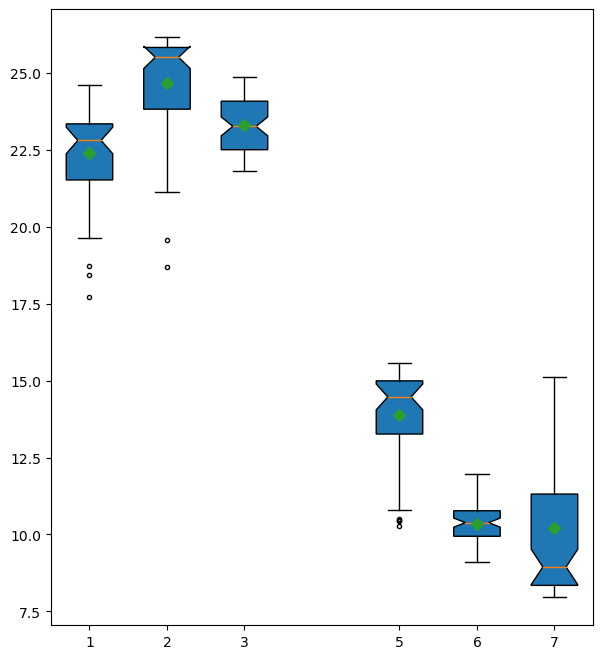

In [24]:
fig, ax = plt.subplots(figsize=(7, 8))

# customize the boxplot elements
meanpointprops = dict(marker='D')

# add the data to the plot
bp_surf = ax.boxplot(surface_data, positions=[1, 2, 3], widths=0.6, patch_artist=True, showmeans=True,
                     notch=True, meanprops=meanpointprops, sym='.')
bp_bottom = ax.boxplot(bottom_data, positions=[5, 6, 7], widths=0.6, patch_artist=True, showmeans=True,
                       notch=True, meanprops=meanpointprops, sym='.')


There's a first draft of our boxplot, but we want to customize it more by using specific colors for the boxes and adding labels and a figure legend. There are multiple ways to do this, but one way I've found is the function below that specifies the box colors you want.

In [25]:
def set_box_colors(bp, colors):
    # bp is the boxplot figure object
    # colors is the list of colors you want to use
    for key in ['boxes', 'medians', 'fliers', 'means']:
        for patch, color in zip(bp[key], colors):
            patch.set_color(color)
            if key == 'boxes':
                patch.set_facecolor('none')
            elif key == 'means':
                patch.set_markerfacecolor(color)
                patch.set_markeredgecolor(color)
            elif key == 'fliers':
                patch.set_markeredgecolor(color)

    wc_colors = [x for pair in zip(colors, colors) for x in pair]
    for key in ['whiskers', 'caps']:
        for patch, color in zip(bp[key], wc_colors):
            patch.set_color(color)

Ok, let's make that boxplot again and add some more customization.

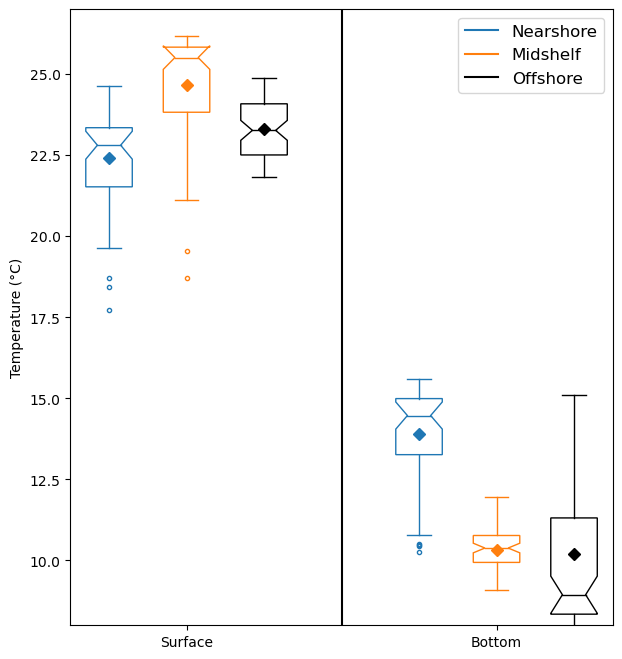

In [26]:
fig, ax = plt.subplots(figsize=(7, 8))

# customize the boxplot elements
meanpointprops = dict(marker='D')

bp_surf = ax.boxplot(surface_data, positions=[1, 2, 3], widths=0.6, patch_artist=True, showmeans=True,
                     notch=True, meanprops=meanpointprops, sym='.')
bp_bottom = ax.boxplot(bottom_data, positions=[5, 6, 7], widths=0.6, patch_artist=True, showmeans=True,
                       notch=True, meanprops=meanpointprops, sym='.')

# set box colors
set_box_colors(bp_surf, box_colors)
set_box_colors(bp_bottom, box_colors)

# draw temporary lines and use them to create a legend
plt.plot([], c='tab:blue', label='Nearshore')
plt.plot([], c='tab:orange', label='Midshelf')
plt.plot([], c='k', label='Offshore')
plt.legend(fontsize=12)

# set axes labels
ax.set_xticks([2, 6])
ax.set_xticklabels(['Surface', 'Bottom'])
ax.set_ylabel('Temperature (\N{DEGREE SIGN}C)')

# draw a horizontal line between sections
ylims = [8, 27]
ax.set_ylim(ylims)
ax.vlines(4, ylims[0], ylims[1], colors='k')

sfilename = f'{deployment_id}_boxplot_temperature.png'
sfile = os.path.join(save_dir, sfilename)
plt.savefig(sfile, dpi=300)

There's the final boxplot! Now let's export a .csv file with some summary statistics. I wrote a function to calculate some statistics for each box in the box plot:

In [27]:
def build_summary(data, summary_dict, summary_dict_key):
    """
    :param data: data in the form of a numpy array
    :param summary_dict: dictionary to which summary data are appended
    :param summary_dict_key: key for dictionary
    :return:
    """
    if len(data) == 0:
        summary_dict[summary_dict_key] = dict(count=len(data),
                                              median=np.nan,
                                              mean=np.nan,
                                              lower_quartile=np.nan,
                                              upper_quartile=np.nan,
                                              lower_whisker=np.nan,
                                              upper_whisker=np.nan,
                                              min=np.nan,
                                              max=np.nan)
    else:
        lq = np.percentile(data, 25)
        uq = np.percentile(data, 75)
        iqr = uq - lq
        summary_dict[summary_dict_key] = dict(count=int(len(data)),
                                              median=np.round(np.nanmedian(data), 4),
                                              mean=np.round(np.nanmean(data), 4),
                                              lower_quartile=np.round(lq, 4),
                                              upper_quartile=np.round(uq, 4),
                                              lower_whisker=data[data >= lq - 1.5 * iqr].min(),
                                              upper_whisker=data[data <= uq + 1.5 * iqr].max(),
                                              min=np.round(np.nanmin(data), 4),
                                              max=np.round(np.nanmax(data), 4))

Let's build a dictionary with all of the statistics for each box.

In [28]:
# make summary to export as csv
summary_dict = dict()

build_summary(nearsurf, summary_dict, 'nearshore_surface')
build_summary(midsurf, summary_dict, 'midshelf_surface')
build_summary(offsurf, summary_dict, 'offshore_surface')
build_summary(nearbot, summary_dict, 'nearshore_bottom')
build_summary(midbot, summary_dict, 'midshelf_bottom')
build_summary(offbot, summary_dict, 'offshore_bottom')

summary_dict

{'nearshore_surface': {'count': 44,
  'median': 22.8074,
  'mean': 22.4126,
  'lower_quartile': 21.5238,
  'upper_quartile': 23.3474,
  'lower_whisker': 19.625977,
  'upper_whisker': 24.62474,
  'min': 17.7243,
  'max': 24.6247},
 'midshelf_surface': {'count': 75,
  'median': 25.5102,
  'mean': 24.6765,
  'lower_quartile': 23.8242,
  'upper_quartile': 25.8318,
  'lower_whisker': 21.131266,
  'upper_whisker': 26.162252,
  'min': 18.7091,
  'max': 26.1623},
 'offshore_surface': {'count': 65,
  'median': 23.2655,
  'mean': 23.3081,
  'lower_quartile': 22.5069,
  'upper_quartile': 24.0843,
  'lower_whisker': 21.822817,
  'upper_whisker': 24.886154,
  'min': 21.8228,
  'max': 24.8862},
 'nearshore_bottom': {'count': 42,
  'median': 14.4691,
  'mean': 13.8933,
  'lower_quartile': 13.2627,
  'upper_quartile': 14.992,
  'lower_whisker': 10.784423,
  'upper_whisker': 15.58191,
  'min': 10.2735,
  'max': 15.5819},
 'midshelf_bottom': {'count': 77,
  'median': 10.3826,
  'mean': 10.3343,
  'lower

In [29]:
# convert the dictionary to a dataframe
summary_df = pd.DataFrame(summary_dict)
summary_df

,nearshore_surface,midshelf_surface,offshore_surface,nearshore_bottom,midshelf_bottom,offshore_bottom
count,44.000000,75.000000,65.000000,42.000000,77.000000,66.000000
median,22.807400,25.510201,23.265499,14.469100,10.382600,8.942200
mean,22.412600,24.676500,23.308100,13.893300,10.334300,10.197500
lower_quartile,21.523800,23.824200,22.506900,13.262700,9.939100,8.342700
upper_quartile,23.347400,25.831800,24.084300,14.992000,10.769400,11.311300
lower_whisker,19.625977,21.131266,21.822817,10.784423,9.091057,7.955571
upper_whisker,24.624741,26.162252,24.886154,15.581910,11.970337,15.101389
min,17.724300,18.709101,21.822800,10.273500,9.091100,7.955600
max,24.624701,26.162300,24.886200,15.581900,11.970300,15.101400


In [30]:
# round all of the values and export as .csv
summary_df = summary_df.round(2)
csv_filename = f'{deployment_id}_boxplot_summary_temperature.csv'
csv_save = os.path.join(save_dir, csv_filename)
summary_df.to_csv(csv_save)
print(f'Summary .csv file saved to: {csv_save}')

Summary .csv file saved to: /Users/garzio/Documents/rucool/gliderplots/ru30-20190717T1812-delayed_boxplot_summary_temperature.csv
